# Appendix: Code testing and verification with Manufactured Solutions

An important part of developing code is continuous integration and testing - for codes that simulate physical phenomena by solving a system of PDEs, this involves code verification as dicussed in detail in this [Sandia National Laboratories report](https://www.osti.gov/servlets/purl/759450-wLI4Ux/native/):

*“The [code] author defines precisely what continuum partial differential
equations and continuum boundary conditions are being solved, and
convincingly demonstrates that they are solved correctly, i.e., usually with
some order of accuracy, and always consistently, so that as some measure of
discretization (e.g. the mesh increments) $\Delta\to0$, the code produces a solution
to the continuum equations; this is Verification."*

This has been included in this project in two ways:
- For each ODE class a ``rhs_analytic`` function needs to be defined which can be used for probing the right (i.e. expected) order of convergence for the spatial discretization of the numerical right-hand side.
- The method of manufactured solutions (MMS) can also be used to test the order of time integration and compare various discretizations of the same initial-boundary-value problem.

## Method of Manufactured Solution (MMS)

The main idea of this approach is to construct test cases where the solution to a problem is known a-priori. This means for example when testing the discretization of a spatial derivative, one considers functions, where the continuous counterpart can be computed analytically. We make this more precise in the following sections.
A detailed introduction to MMS can be found [here](https://www.osti.gov/servlets/purl/759450-wLI4Ux/native/).


In the following we show some examples which are all part of the CI testing of the codebase. They can be found in the test folder in the files `test_laplace.py` and `test_rhs.py`.

In a nutshell, it is as simple as this (for the leading example $-\Delta u = \text{rhs}$)

1. Define a test function $u_\text{analytic}(x,y,z)$ which is given analytically in sympy logic
2. Compute the exact solution to the right-hand side (e.g. $\text{rhs}_\text{analytic} = -\Delta u_\text{analytic}$ via sympy) and evaluate it on the defined grid $$\text{rhs}_\text{analytic}=\text{rhs}_\text{analytic}(x_i, y_j, z_k),$$ where $(x_i, y_j, z_k)$ are the discrete positions in the regular meshgrid.
3. Compute the discrete initial field $u_\text{numeric}(x_i, y_j, z_k)$ and the corresponding numerical right-hand side (e.g. $\text{rhs}_\text{numeric} = - \Delta_h  u_\text{numeric}$ for a stencil $\Delta_h$) $$\text{rhs}_\text{numeric}=\text{rhs}_\text{numeric}(u_\text{numeric})$$
4. Compute the relative $L_2$ error i.e. the discrete $L_2$–norm of the difference $\text{rhs}_\text{numeric}-\text{rhs}_\text{analytic}$ divided by the $L_2$–norm of the analytical solution $$\epsilon = \sqrt{\sum_{i,j,k} (\text{rhs}_\text{numeric}-\text{rhs}_\text{analytic})^2} \bigg/ \sqrt{\sum_{i,j,k} (\text{rhs}_\text{analytic})^2}$$

Repeat the scheme for various spatial discretizations $\Delta x$ on the same physical domain with the same analytical reference. Since it is known from the theory that the error $\epsilon$ scales like a constant times $h^p$ for the mesh width $h = \max\{\Delta x, \Delta y, \Delta z \}$ and some integer $p$, we obtain the relation
$$
\log \epsilon \sim \log C + p \log h ,
$$
which corresponds in a log-log-plot to a straight line with slope $p$. This slope $p$ (computed via linear regression) is then compared to the theoretically expected exponent to validate the implementation.

## Spatial order of convergence for Laplacian stencils

First we define a function to automatically perform the convergence test. This can be found in a similar fashion in the ``utils.py`` file.

In [1]:
import numpy as np
import evoxels as evo

def grid_convergence_test(
    test_function,
    rhs_analytic,
    rhs_numerical,
    convention = 'cell_center',
    dtype = 'float32',
    powers = np.array([3,4,5,6,7]),
):
    dx     = np.zeros(len(powers))
    errors = np.zeros(len(powers))

    for i, p in enumerate(powers):
        if convention == 'cell_center':
            vf = evo.VoxelFields((2**p, 2**p, 2**p), (1,1,1), convention=convention)
        elif convention == 'staggered_x':
            vf = evo.VoxelFields((2**p+1, 2**p, 2**p), (1,1,1), convention=convention)
        vf.precision = dtype
        grid = vf.meshgrid()
        init_data = test_function(*grid)

        vg = evo.voxelgrid.VoxelGridTorch(vf.grid_info(), precision=vf.precision, device='cpu')
        field = vg.init_scalar_field(init_data)

        # Compute solutions
        comp = vg.export_scalar_field_to_numpy(rhs_numerical(vg, field))
        exact = rhs_analytic(*grid)
        if convention == 'staggered_x':
            exact = exact[1:-1,:,:]

        # Error norm
        diff = comp - exact
        errors[i] = np.linalg.norm(diff)/np.linalg.norm(exact)
        dx[i]     = vf.spacing[0]

    slope, _ = np.polyfit(np.log(dx), np.log(errors), 1)
    print(f"Grid spacing: {dx}")
    print("Convergence rate from slope fit:", slope)
    return dx, errors, slope

Let's start with a laplace stencil combined with zero-flux (Neumann) boundary conditions. Both grid conventions exhibit the expected second order convergence.

Grid spacing: [0.125     0.0625    0.03125   0.015625  0.0078125]
Convergence rate from slope fit: 1.9533270430146406
Grid spacing: [0.125     0.0625    0.03125   0.015625  0.0078125]
Convergence rate from slope fit: 2.0915744090903576


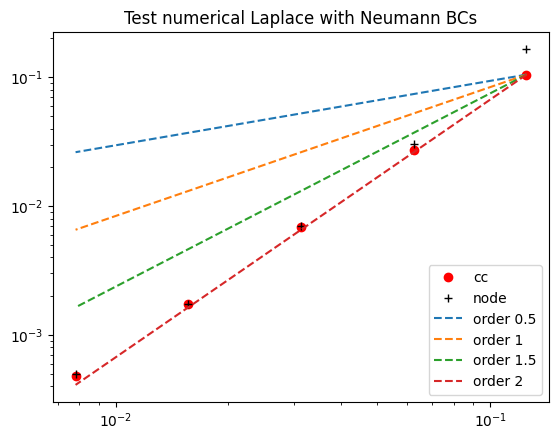

In [2]:
from numpy import sin, cos, pi
import matplotlib.pyplot as plt

def test_function(x,y,z):
    return cos(pi*x)**3

def laplace_analytical(x,y,z):
    return  3*pi**2*(2*sin(pi*x)**2 - cos(pi*x)**2)*cos(pi*x)
    
def rhs_fun(vg, field):
    field = vg.bc.trim_boundary_nodes(field)
    field = vg.bc.pad_zero_flux_periodic(field)
    laplace = vg.laplace(field)
    return laplace

dx1, errors1, slope1 = grid_convergence_test(
    test_function, laplace_analytical, rhs_fun,
    convention = 'cell_center',
)

dx2, errors2, slope2 = grid_convergence_test(
    test_function, laplace_analytical, rhs_fun,
    convention = 'staggered_x',
)

plt.loglog(dx1, errors1, 'o', label='cc', color='red')
plt.loglog(dx2, errors2, '+', label='node', color='black')
plt.loglog(dx1, errors1[0]/dx1[0]**0.5*dx1**0.5, '--', label = 'order 0.5')
plt.loglog(dx1, errors1[0]/dx1[0]*dx1,'--', label = 'order 1')
plt.loglog(dx1, errors1[0]/dx1[0]**1.5*dx1**1.5,'--', label = 'order 1.5')
plt.loglog(dx1, errors1[0]/dx1[0]**2*dx1**2,'--', label = 'order 2')
plt.legend()
plt.title('Test numerical Laplace with Neumann BCs')
plt.show()

Next, let's move on to Dirichlet boundary conditions $u(x=0)=u(x=1)=0$.
There are two ways to enforce Dirichlet boundary conditions depending on the grid convention.
1. Cell centered grid: Works with ghost nodes and the value of $u$ outside the domain is set accordingly. Commonly, $u_\text{ghost} = 2u_\text{BC} - u(\frac{\Delta x}{2})$ is used as this reproduces the correct boundary value with linear interpolation ($u(0)=0.5(u_\text{ghost}+u(\frac{\Delta x}{2}))=u_\text{BC})$.
2. In a staggered grid configuration, the nodes at which the concentration values are stored, actually lie on the domain boundary and can be set to the corresponding given boundary value $u_\text{BC}$

Grid spacing: [0.125     0.0625    0.03125   0.015625  0.0078125]
Convergence rate from slope fit: 0.4954937374912848
Grid spacing: [0.125     0.0625    0.03125   0.015625  0.0078125]
Convergence rate from slope fit: 2.0314069655338005


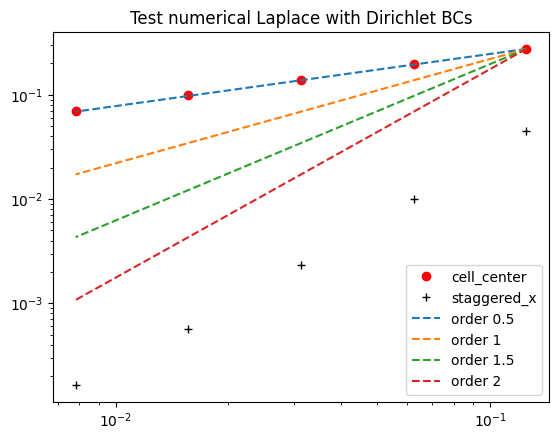

In [3]:
def test_function(x,y,z):
    return (x*(1-x))**2

def laplace_analytical(x,y,z):
    return 2 - 12*x + 12*x**2

def rhs_fun(vg, field):
    field = vg.bc.trim_boundary_nodes(field)
    field = vg.bc.pad_dirichlet_periodic(field, bc0=0, bc1=0)
    laplace = vg.laplace(field)
    return laplace

dx1, errors1, slope1 = grid_convergence_test(
    test_function, laplace_analytical, rhs_fun,
    convention = 'cell_center',
)

dx2, errors2, slope2 = grid_convergence_test(
    test_function, laplace_analytical, rhs_fun,
    convention = 'staggered_x',
)

plt.loglog(dx1, errors1, 'o', label='cell_center', color='red')
plt.loglog(dx2, errors2, '+', label='staggered_x', color='black')
plt.loglog(dx1, errors1[0]/dx1[0]**0.5*dx1**0.5, '--', label = 'order 0.5')
plt.loglog(dx1, errors1[0]/dx1[0]*dx1,'--', label = 'order 1')
plt.loglog(dx1, errors1[0]/dx1[0]**1.5*dx1**1.5,'--', label = 'order 1.5')
plt.loglog(dx1, errors1[0]/dx1[0]**2*dx1**2,'--', label = 'order 2')
plt.legend()
plt.title(f'Test numerical Laplace with Dirichlet BCs')
plt.show()

While the staggered grid convention shows the right order of convergence, the cell centered grid only converges with polynomial order $p=0.5$ which underlines **how important it is to test the discretized operators in combination with boundary conditions!**

This can also be shown by Taylor series expansion, where generally
$$f(x+h) = f(x) + f'(x)h + \frac{1}{2}f''(x)h^2 + \frac{1}{6}f'''(x)h^3 + \mathcal{O}(h^4)$$
which means that for the first inner node in a cell centered grid at $x=\frac{\Delta x}{2}$ we can add $f(\frac{3\Delta x}{2}) +2f(0)$ to cancel the first order term which yields
$$f(3\Delta x /2) +2f(0) = 3f(\Delta x/2) + \frac{3}{4}f''(\Delta x/2)h^2 + \frac{5}{24}f'''(\Delta x/2)h^3 + \mathcal{O}(h^4)$$
and therefore, the second order spatial discretization is only first order accurate if we introduce a correction
$$f''(\Delta x/2) = \frac{4}{3} \frac{f(3\Delta x /2) - 3f(\Delta x/2) + 2f(0)}{h^2} + \mathcal{O}(h)$$

With the standard laplace scheme (no boundary correction), not even the first order term cancels which results in very slow convergence. We can test the corrected Laplace scheme:

In [4]:
def rhs_laplace_v2(vg, field):
    field = vg.bc.trim_boundary_nodes(field)
    padded = vg.bc.pad_dirichlet_periodic(field, bc0=0, bc1=0)

    laplace = (padded[:, 1:-1, 2:, 1:-1] + padded[:, 1:-1, :-2, 1:-1]) * vg.div_dx2[1] + \
              (padded[:, 1:-1, 1:-1, 2:] + padded[:, 1:-1, 1:-1, :-2]) * vg.div_dx2[2] - \
              2 * padded[:, 1:-1, 1:-1, 1:-1] * (vg.div_dx2[1]+vg.div_dx2[2])
    laplace[:,1:-1,:,:] += (padded[:, 3:-1, 1:-1, 1:-1] - 2*padded[:, 2:-2, 1:-1, 1:-1] + padded[:, 1:-3, 1:-1, 1:-1]) * vg.div_dx2[0]
    laplace[:,0,:,:]  += (padded[:, 2, 1:-1, 1:-1] - 3*padded[:, 1, 1:-1, 1:-1] + 2*0) * vg.div_dx2[0] * 4/3
    laplace[:,-1,:,:] += (padded[:,-3, 1:-1, 1:-1] - 3*padded[:,-2, 1:-1, 1:-1] + 2*0) * vg.div_dx2[0] * 4/3
    return laplace

Grid spacing: [0.125     0.0625    0.03125   0.015625  0.0078125]
Convergence rate from slope fit: 1.4448431854689416


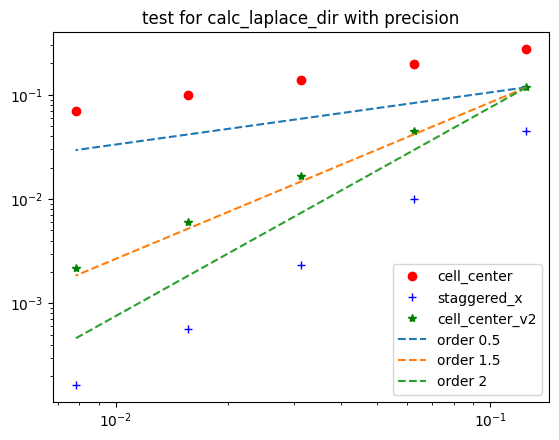

In [5]:
dx3, errors3, slope3 = grid_convergence_test(
    test_function, laplace_analytical, rhs_laplace_v2,
    convention = 'cell_center',
)

plt.loglog(dx1, errors1, 'o', color='red', label='cell_center')
plt.loglog(dx2, errors2, '+', color='blue', label='staggered_x')
plt.loglog(dx3, errors3, '*', color='green', label='cell_center_v2')
plt.loglog(dx3, errors3[0]/dx2[0]**0.5*dx2**0.5, '--', label='order 0.5')
plt.loglog(dx3, errors3[0]/dx2[0]**1.5*dx2**1.5, '--', label='order 1.5')
plt.loglog(dx3, errors3[0]/dx2[0]**2*dx2**2, '--', label='order 2')
plt.legend()
plt.title(f'test for calc_laplace_dir with precision')
plt.show()

## Testing ODE right-hand sides

The ODEs are all given in the form $\partial_t u = \text{rhs}(t,u)$, e.g. for Allen-Cahn in the form $\text{rhs}(t,u) = \Delta u + g(t,u)$.

The above procedure has been adapted to automatically test all implementations of ODE classes by comparing the ``rhs_analytic`` to the results produced by ``rhs``. This ensures two things
1. Does the ``rhs`` function implement a discretized version of the envisioned PDE?
2. Does the chosen discretization converge at the expected spatial order of convergence?

This is illustrated for the implemented Allen-Cahn type phase evolution problem below:

Grid spacing: [0.125     0.0625    0.03125   0.015625  0.0078125]
Errors:       [0.19028211 0.05396869 0.01346211 0.00334846 0.00102839]
Convergence rate from slope fit: 1.907376693930398
Expected order of convergence:   2


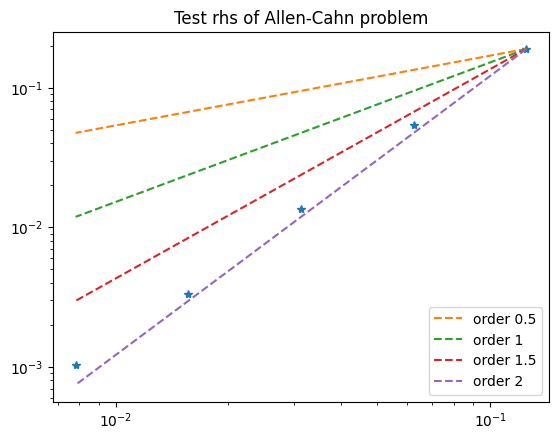

In [6]:
from evoxels.problem_definition import AllenCahnEquation
from evoxels.utils import rhs_convergence_test
import sympy as sp
import sympy.vector as spv

CS = spv.CoordSys3D('CS')
test_fun = 0.5 + 0.3 * sp.cos(4*sp.pi*CS.x)\
                     * sp.cos(2*sp.pi*CS.y)\
                     * (CS.z**2/2 - CS.z**3/3)

dx, errors, slope, order = rhs_convergence_test(
    ODE_class      = AllenCahnEquation,
    problem_kwargs = {'eps': 3.0, 'curvature': 0.5},
    test_function  = test_fun,
    convention     = 'cell_center',
    dtype          = 'float64'
)

print(f"Grid spacing: {dx}")
print(f"Errors:       {errors}")
print("Convergence rate from slope fit:", slope)
print("Expected order of convergence:  ", order)

plt.loglog(dx, errors,'*')
plt.loglog(dx, errors[0]/dx[0]**0.5*dx**0.5, '--', label = 'order 0.5')
plt.loglog(dx, errors[0]/dx[0]*dx,'--', label = 'order 1')
plt.loglog(dx, errors[0]/dx[0]**1.5*dx**1.5,'--', label = 'order 1.5')
plt.loglog(dx, errors[0]/dx[0]**2*dx**2,'--', label = 'order 2')
plt.legend()
plt.title(f'Test rhs of Allen-Cahn problem')
plt.show()

## Time-dependent problems

The idea of manufactured solutions can further be generalized to problems of the form
$$
\partial_t u (t,x) = \text{rhs}(t,x,u)
$$
where for example in Allen-Cahn $\text{rhs}(t,x,u) = \Delta u + g(t,u)$. For a general problem it is often difficult to test the problem with a known solution in order to determine if the code produces the correct solution. One can therefore simply study the modified problem
$$
\partial_t u (t,x) = \text{rhs}(t,x,u) + f_{\text{ex}}(t,x) \qquad (+)
$$
with an artificial forcing term $f_{\text{ex}}$. This allows the following construction:
1. Choose some analytically given function $u (t,x)$.
2. Define $f_{\text{ex}}(t,x) = \partial_t u (t,x) - \text{rhs}(t,x,u)$ (again computable via sympy)
3. Then $u$ is by construction the exact solution to (+).

If we now pass problem (+) to the solver (i.e. the right-hand side as well as the artificial forcing), then we can compare its approximations at time $t_n$ denoted by $u_{h,n}$ to the exact solution $u(t_n,x_i, y_j, z_k)$. Thus, we can determine if the error behaves asymptotically (i.e. as the time-step size and the mesh width tend to zero) with the correct order.

### Testing the diffusion equation

Define a test function for manufactured solutions testing

In [7]:
import sympy as sp
import sympy.vector as spv

CS = spv.CoordSys3D('CS')
t = sp.symbols('t', real=True)

test_funs_rd = (0.5 + 0.4 * sp.cos(4*sp.pi*CS.x) * sp.cos(2*sp.pi*CS.y)**3 \
                          * sp.cos(t*2*sp.pi)) * sp.exp(-t)

Load the ReactionDiffusion ODE and timesteppers. Then perform various tests.
The ``mode`` argument decides how the manufactured rhs is constructed.
- if ``mode='spatial'``, the analytical rhs is used but temporal convergence is hard to show
- if ``mode='temporal'``, the numerical rhs is applied to the exact solution u(t,grid) to construct the manufactured rhs.

In [8]:
from evoxels.utils import mms_convergence_test
from evoxels.problem_definition import ReactionDiffusion
from evoxels.timesteppers import PseudoSpectralIMEX, ForwardEuler

results1 = mms_convergence_test(
    ODE_class       = ReactionDiffusion,
    timestepper_cls = PseudoSpectralIMEX,
    problem_kwargs  = {"D": 1.0, "BC_type": 'periodic'},
    test_function   = test_funs_rd,
    mode            = 'spatial',
    t_powers        = [8,9,10,11,12,13,14,15],
)

results2 = mms_convergence_test(
    ODE_class       = ReactionDiffusion,
    timestepper_cls = ForwardEuler,
    problem_kwargs  = {"D": 1.0, "BC_type": 'periodic'},
    test_function   = test_funs_rd,
    mode            = 'spatial',
    t_powers        = [8,9,10,11,12,13,14,15],
)

results3 = mms_convergence_test(
    ODE_class       = ReactionDiffusion,
    timestepper_cls = PseudoSpectralIMEX,
    problem_kwargs  = {"D": 1.0, "BC_type": 'periodic'},
    test_function   = test_funs_rd,
    mode            = 'temporal',
    t_powers        = [8,9,10,11,12,13,14,15],
)

results4 = mms_convergence_test(
    ODE_class       = ReactionDiffusion,
    timestepper_cls = ForwardEuler,
    problem_kwargs  = {"D": 1.0, "BC_type": 'periodic'},
    test_function   = test_funs_rd,
    mode            = 'temporal',
    t_powers        = [8,9,10,11,12,13,14,15],
)

Helper function from utils to visualize the resulting error landscapes as a function od dt and dx. If the solver exits with NaN error, the L2 norm is set to Nan as well. 

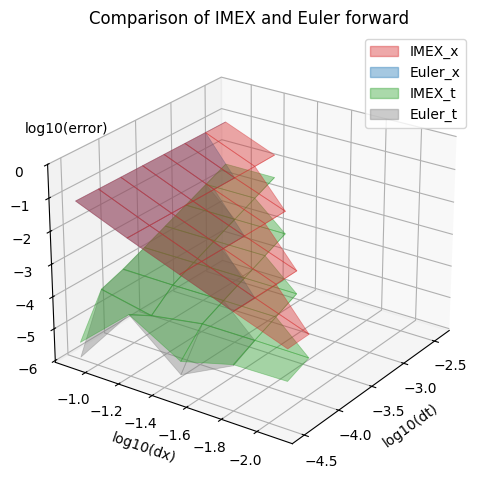

In [9]:
from evoxels.utils import plot_error_surface

results1['name'] = 'IMEX_x'
results2['name'] = 'Euler_x'
results3['name'] = 'IMEX_t'
results4['name'] = 'Euler_t'
title = 'Comparison of IMEX and Euler forward'
plot_error_surface([results1, results2, results3, results4], title=title)

Exmple with coupled reaction diffusion equation

In [10]:
from evoxels.problem_definition import CoupledReactionDiffusion
test_funs_rd = (0.5 + 0.4 * sp.cos(2*sp.pi*CS.x) * sp.cos(2*sp.pi*CS.y)**3 * (sp.cos(t*2*sp.pi)),
                0.4 + 0.1 * sp.sin(4*sp.pi*CS.x) *sp.exp(-t/10))

results5 = mms_convergence_test(
    ODE_class       = CoupledReactionDiffusion,
    timestepper_cls = PseudoSpectralIMEX,
    problem_kwargs  = {"D_A": 1.0, "D_B": 0.5},
    test_function   = test_funs_rd,
    mode            = 'spatial',
    t_powers        = [8,9,10],
)

results6 = mms_convergence_test(
    ODE_class       = CoupledReactionDiffusion,
    timestepper_cls = PseudoSpectralIMEX,
    problem_kwargs  = {"D_A": 1.0, "D_B": 0.5},
    test_function   = test_funs_rd,
    mode            = 'temporal',
    t_powers        = [8,9,10],
)

In [14]:
print("Spatial convergence rate from slope fit:", results5['g_slopes'])
print("Expected order of convergence:  ", results5['g_order'])
print("Temporal convergence rate from slope fit:", results6['t_slopes'])
print("Expected order of convergence:  ", results6['t_order'])

Spatial convergence rate from slope fit: [2.10641026 1.97092643]
Expected order of convergence:   2
Temporal convergence rate from slope fit: [1.16403104 0.9977435 ]
Expected order of convergence:   1


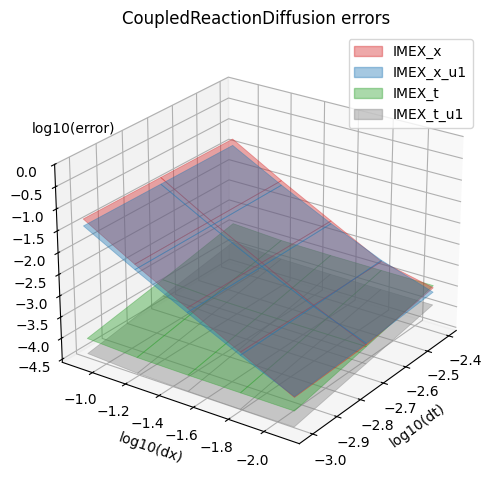

In [12]:
results5['name'] = 'IMEX_x'
results6['name'] = 'IMEX_t'
plot_error_surface([results5, results6], title='CoupledReactionDiffusion errors')